<a href="https://colab.research.google.com/github/parteeksingh24/ECS171_FinalProject/blob/main/ForestFiresProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# Import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.svm import OneClassSVM, SVR
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from itertools import product

In [14]:
# Load the forest fires dataset
df_forest_fires = pd.read_csv('forest+fires/forestfires.csv')
print(df_forest_fires)

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]


In [15]:
# Initial data exploration
df_forest_fires.info() # Check data structure
df_forest_fires.describe() # Check basic statistics about dataset
df_forest_fires.isnull().sum() # Make sure no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

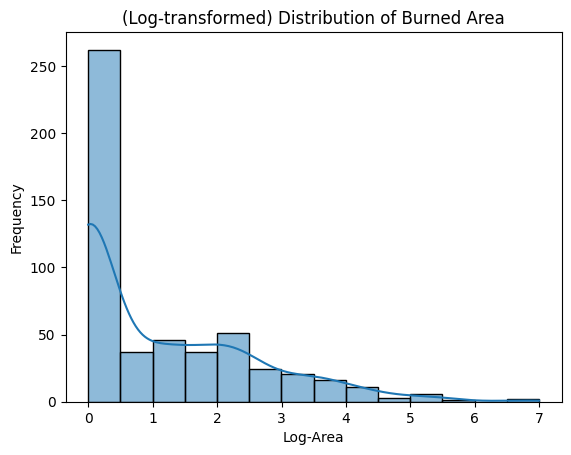

In [16]:
# Visualize data distribution

# Create binary target variable -- has a fire occured or not?
df_forest_fires['fire_occurred'] = df_forest_fires['area'].apply(lambda x: 1 if x > 0 else 0)
# Column based on the Area > 0 or = 0

# Display 'area' (target variable) using a histogram
# Apply  log transformation to 'area' to reduce skewness, improve visualization
df_forest_fires['log_area'] = np.log1p(df_forest_fires['area'])
sns.histplot(df_forest_fires['log_area'], kde=True)
plt.title('(Log-transformed) Distribution of Burned Area')
plt.xlabel('Log-Area')
plt.ylabel('Frequency')
plt.show()

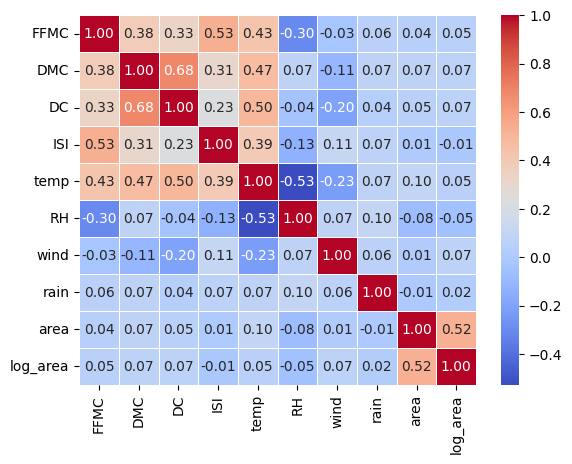

In [17]:
# Explore variable correlations
df_forest_fires_cont_vars = df_forest_fires.drop(columns = ['X', 'Y', 'month', 'day', 'fire_occurred'])
cont_vars_corr_matrix = df_forest_fires_cont_vars.corr()
heatmap = sns.heatmap(cont_vars_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

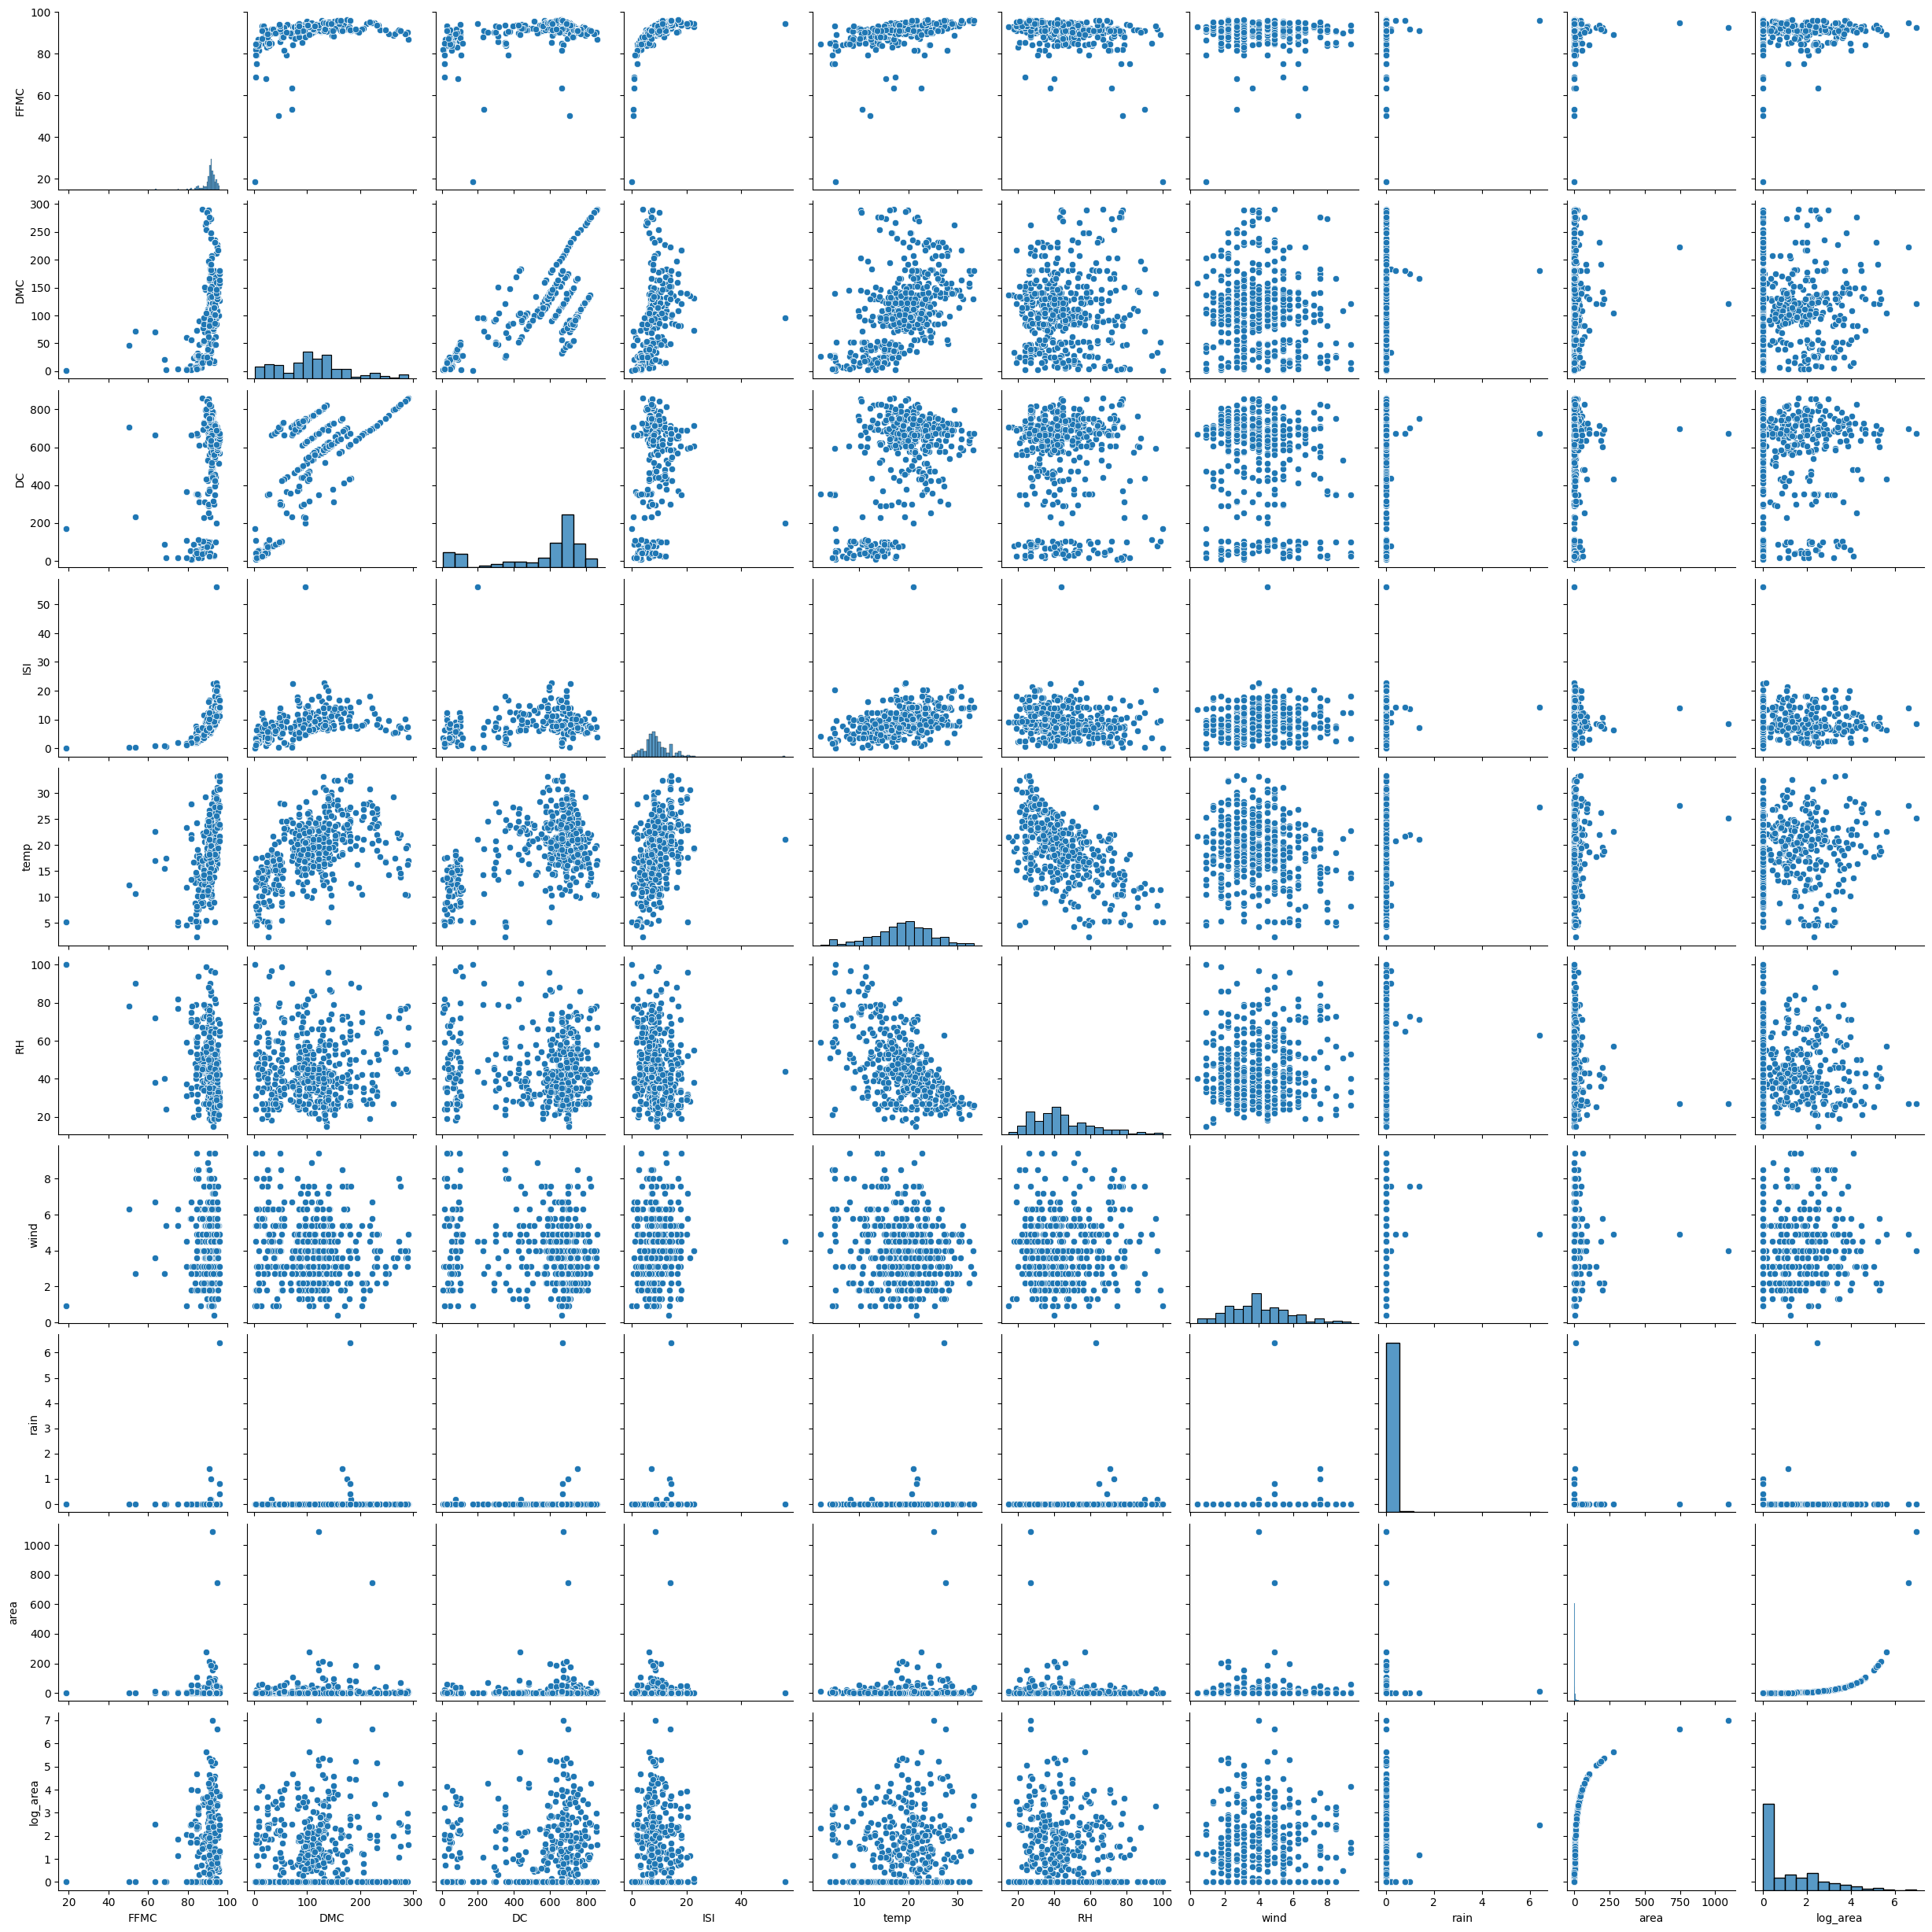

In [19]:
# Create pairplot based on fire occurrence
pairplot = sns.pairplot(df_forest_fires_cont_vars, diag_kind='hist')

Not sure how to better setup these pairplots or other plots to use to beneficially discover correlation

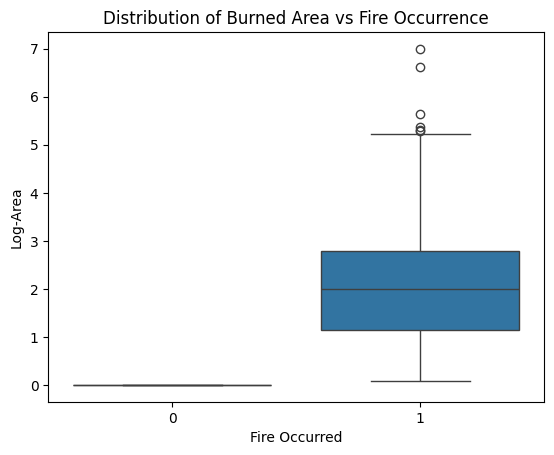

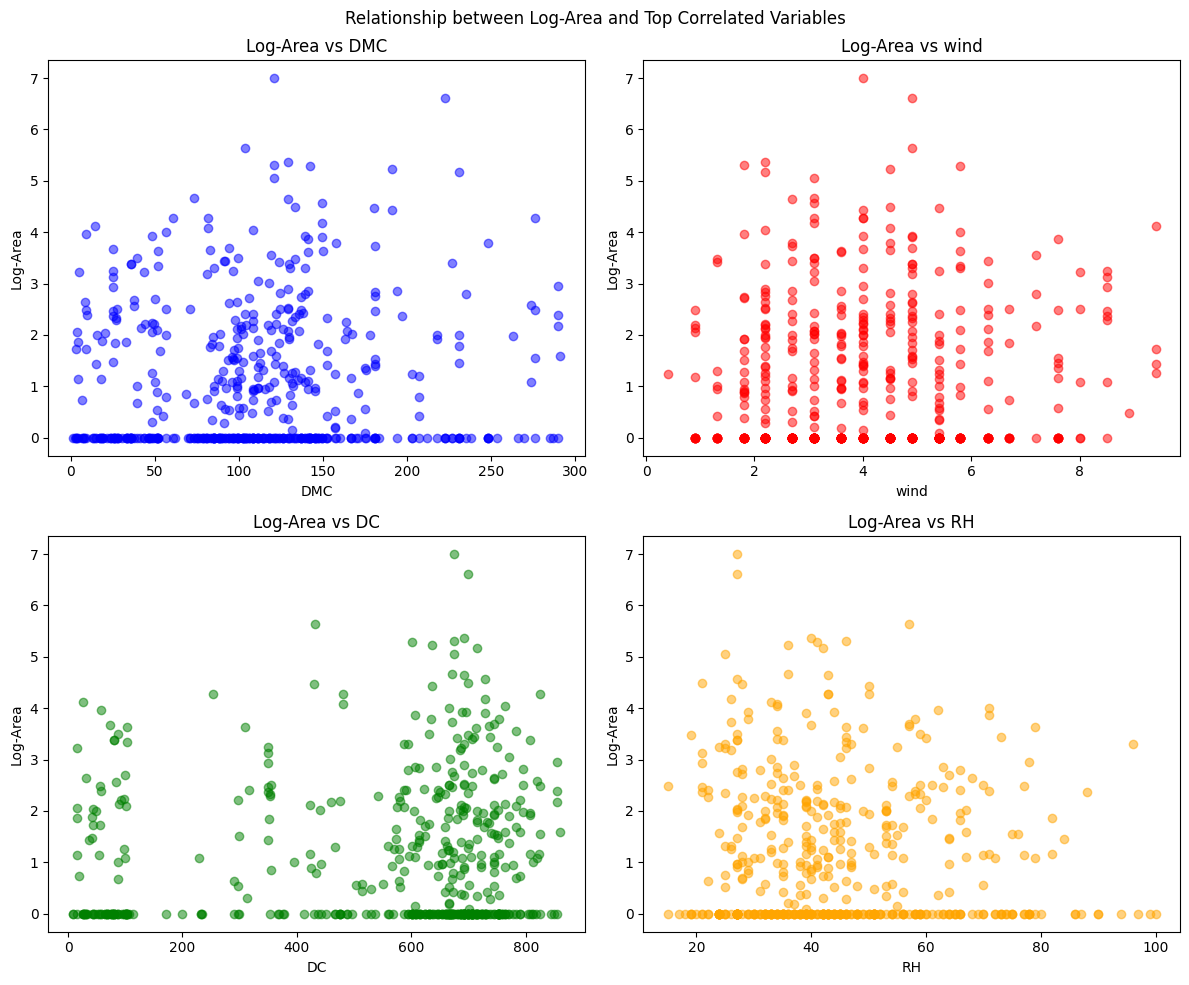

In [23]:
# Boxplot of 'log_area' against 'fire_occurred' to show the distribution of burn areas where fires did and did not occur
sns.boxplot(x='fire_occurred', y='log_area', data=df_forest_fires)
plt.title('Distribution of Burned Area vs Fire Occurrence')
plt.xlabel('Fire Occurred')
plt.ylabel('Log-Area')
plt.show()

# Select the most correlated variables with 'log_area'
top_corr_vars = cont_vars_corr_matrix['log_area'].abs().nlargest(7).index.tolist()[2:6]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Relationship between Log-Area and Top Correlated Variables')

axes[0, 0].scatter(df_forest_fires[top_corr_vars[0]], df_forest_fires['log_area'], color='blue', alpha=0.5)
axes[0, 0].set_title(f'Log-Area vs {top_corr_vars[0]}')
axes[0, 0].set_xlabel(top_corr_vars[0])
axes[0, 0].set_ylabel('Log-Area')

axes[0, 1].scatter(df_forest_fires[top_corr_vars[1]], df_forest_fires['log_area'], color='red', alpha=0.5)
axes[0, 1].set_title(f'Log-Area vs {top_corr_vars[1]}')
axes[0, 1].set_xlabel(top_corr_vars[1])
axes[0, 1].set_ylabel('Log-Area')

axes[1, 0].scatter(df_forest_fires[top_corr_vars[2]], df_forest_fires['log_area'], color='green', alpha=0.5)
axes[1, 0].set_title(f'Log-Area vs {top_corr_vars[2]}')
axes[1, 0].set_xlabel(top_corr_vars[2])
axes[1, 0].set_ylabel('Log-Area')

axes[1, 1].scatter(df_forest_fires[top_corr_vars[3]], df_forest_fires['log_area'], color='orange', alpha=0.5)
axes[1, 1].set_title(f'Log-Area vs {top_corr_vars[3]}')
axes[1, 1].set_xlabel(top_corr_vars[3])
axes[1, 1].set_ylabel('Log-Area')

plt.tight_layout()
plt.show()

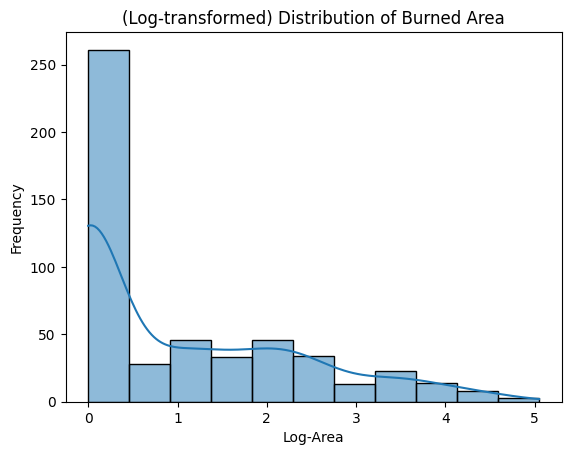

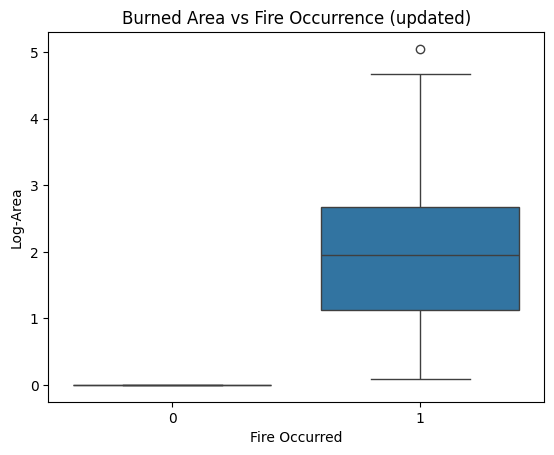

In [57]:
# Remove outliers
Q1 = df_forest_fires['log_area'].quantile(0.25)
Q3 = df_forest_fires['log_area'].quantile(0.75)
IQR = Q3 - Q1

is_outlier = (df_forest_fires['log_area'] < (Q1 - 1.5 * IQR)) | (df_forest_fires['log_area'] > (Q3 + 1.5 * IQR))
df_updated = df_forest_fires[~is_outlier]
df_updated.reset_index(drop=True, inplace=True)

# Display histogram again, with outliers removed
sns.histplot(df_updated['log_area'], kde=True)
plt.title('(Log-transformed) Distribution of Burned Area')
plt.xlabel('Log-Area')
plt.ylabel('Frequency')
plt.show()

# Display boxplot again, with outliers removed
sns.boxplot(x='fire_occurred', y='log_area', data=df_updated)
plt.title('Burned Area vs Fire Occurrence (updated)')
plt.xlabel('Fire Occurred')
plt.ylabel('Log-Area')
plt.show()

In [58]:
# Display the dataset and filtered dataset shape
print(df_forest_fires.shape)
print(df_updated.shape)

(517, 15)
(509, 15)


In [86]:
# Define feature matrix & target
X = df_updated.drop(['area', 'log_area', 'fire_occurred'], axis=1)
y = df_updated[['area', 'log_area']]

In [87]:
#Use optimized parameters
gradient_descent_model_opt = SGDRegressor(
    loss='squared_error',
    penalty = 'l1',
    max_iter=1000, 
    tol=1e-3, 
    random_state=42,
    alpha = 0.1,
    epsilon = 0.01,
    verbose = 1,
    learning_rate = 'invscaling',
    eta0 = 0.06,
    power_t = 0.25,
    validation_fraction = 0.1,
    early_stopping = False,
    n_iter_no_change = 5,

)

In [88]:
# Initialize the MLPRegressor with the best parameters
mlp = MLPRegressor(
    hidden_layer_sizes=(35,),  # one hidden layer with 35 neurons
    activation='relu',
    solver='adam',
    alpha=0.3,
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=5,
    verbose=False
)

In [95]:
# Initialize the SVRegressor with the best parameters
svr = SVR(
    kernel = 'rbf',
    C = 10,
    gamma = 0.01,
    epsilon = 0.1,
    tol = 1e-3,
    max_iter = -1
)

In [96]:
# Perform 100 fold cross validation on the 3 models
RMSE = {"sgd" : [], "mlp" : [], "svr" : []}
R2 = {"sgd" : [], "mlp" : [], "svr" : []}
MAE = {"sgd" : [], "mlp" : [], "svr" : []}

selected_features = ['temp', 'RH', 'wind', 'rain']

# One-hot encoding for categorical vars ('month', 'day')
categorical_features = ['month', 'day']
one_hot_encoder = OneHotEncoder()
preprocessor = ColumnTransformer(
    transformers=[('cat', one_hot_encoder, categorical_features)],
    remainder='passthrough'
)
X_transform = preprocessor.fit_transform(X)
scaler = StandardScaler()
scaler.fit_transform(X_transform)

# perform 100-fold cross validation
for _ in range(0, 100):
    # Split data (80/20) into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Apply preprocessing for sgd
    X_train_transform = preprocessor.transform(X_train)
    X_test_transform = preprocessor.transform(X_test)
    X_train_scale = scaler.transform(X_train_transform)
    X_test_scale = scaler.transform(X_test_transform)

    # Fit the models
    sgd.fit(X_train_scale, y_train['log_area'])
    mlp.fit(X_train[selected_features], y_train['log_area'])
    svr.fit(X_train[selected_features], y_train['log_area'])
    
    # Make predictions and then transform the area back to its basic form
    sgd_pred = sgd.predict(X_test_scale)
    #print(sgd_pred)
    sgd_pred = pd.DataFrame({'log_area': sgd_pred})
    sgd_pred['area'] = np.expm1(sgd_pred['log_area'])

    mlp_pred = mlp.predict(X_test[selected_features])
    #print(mlp_pred)
    mlp_pred = pd.DataFrame({'log_area': mlp_pred})
    mlp_pred['area'] = np.expm1(mlp_pred['log_area'])

    svr_pred = svr.predict(X_test[selected_features])
    #print(svr_pred)
    svr_pred = pd.DataFrame({'log_area': svr_pred})
    svr_pred['area'] = np.expm1(svr_pred['log_area'])
    
    # Evaluate the models
    RMSE["sgd"].append(np.sqrt(mean_squared_error(y_test['area'], sgd_pred['area'])))
    R2["sgd"].append(r2_score(y_test['area'], sgd_pred['area']))
    MAE["sgd"].append(mean_absolute_error(y_test['area'], sgd_pred['area']))

    RMSE["mlp"].append(np.sqrt(mean_squared_error(y_test['area'], mlp_pred['area'])))
    R2["mlp"].append(r2_score(y_test['area'], mlp_pred['area']))
    MAE["mlp"].append(mean_absolute_error(y_test['area'], mlp_pred['area']))

    RMSE["svr"].append(np.sqrt(mean_squared_error(y_test['area'], svr_pred['area'])))
    R2["svr"].append(r2_score(y_test['area'], svr_pred['area']))
    MAE["svr"].append(mean_absolute_error(y_test['area'], svr_pred['area']))

print(f"SGD Model - RMSE: {sum(RMSE["sgd"]) / len(RMSE["sgd"]):.2f} R2: {sum(R2["sgd"]) / len(R2["sgd"]):.2f} MAE: {sum(MAE["sgd"]) / len(MAE["sgd"]):.2f}")
print(f"MLP Model - RMSE: {sum(RMSE["mlp"]) / len(RMSE["mlp"]):.2f} R2: {sum(R2["mlp"]) / len(R2["mlp"]):.2f} MAE: {sum(MAE["mlp"]) / len(MAE["mlp"]):.2f}")
print(f"SVR Model - RMSE: {sum(RMSE["svr"]) / len(RMSE["svr"]):.2f} R2: {sum(R2["svr"]) / len(R2["svr"]):.2f} MAE: {sum(MAE["svr"]) / len(MAE["svr"]):.2f}")

SGD Model - RMSE: 16.76 R2: -0.11 MAE: 7.17
MLP Model - RMSE: 16.64 R2: -0.10 MAE: 7.53
SVR Model - RMSE: 17.00 R2: -0.15 MAE: 7.08
